```{index} single: Pyomo; kernel library
```
```{index} single: quadratic optimization
```
```{index} single: application; support vector machines
```
```{index} single: application; binary classification
```
```{index} single: application; counterfeit banknotes
```
# Support Vector Machines for Binary Classification

Support Vector Machines (SVM) are a type of supervised machine learning model. Similar to other machine learning techniques based on regression, training an SVM classifier uses examples with known outcomes, and involves optimization some measure of performance. The resulting classifier can then be applied to classify data with unknown outcomes.

In this notebook, we will demonstrate the process of training an SVM for binary classification using linear and quadratic programming. Our implementation will initially focus on linear support vector machines which separate the feature space by means of a hyperplane. We will explore both primal and dual formulations. Then, using kernels, the dual formulation is extended to binary classification in higher-order and nonlinear feature spaces. Several different formulations of the optimization problem are given in AMPL and applied to a banknote classification application.

In [1]:
# install AMPL and solvers
!pip install -q amplpy

SOLVER_LO = "cbc"
SOLVER_NLO = "ipopt"

from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["coin"], # modules to install
    license_uuid="default") # license to use

Please provide a valid license UUID. You can use a free https://ampl.com/ce license.


## Binary classification

Binary classifiers are functions designed to answer questions such as "does this medical test indicate disease?", "will this specific customer enjoy that specific movie?", "does this photo include a car?", or "is this banknote genuine or counterfeit?" These questions are answered based on the values of "features" that may include physical measurements or other types of data collected from a representative data set with known outcomes.

In this notebook we consider a binary classifier that might be installed in a vending machine to detect banknotes. The goal of the device is to accurately identify and accept genuine banknotes while rejecting counterfeit ones. The classifier's performance can be assessed using definitions in following table, where "positive" refers to an instance of a genuine banknote.

| | Predicted Positive  | Predicted Negative | |
| :-- | :--: | :--: | :-- |
| Actual Positive | True Positive (TP) | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN) |

A vending machine user would be frustrated if a genuine banknote is incorrectly rejected as a false negative. **Sensitivity** is defined as the number of true positives (TP) divided by the total number of actual positives (TP + FN). A user of the vending machine would prefer high sensitivity because that means genuine banknotes are likely to be accepted.

The vending machine owner/operator, on the other hand, wants to avoid accepting counterfeit banknotes and would therefore prefer a low number of false positives (FP). **Precision** is the number of true positives (TP) divided by the total number of predicted positives (TP + FP). The owner/operate would prefer high precision because that means almost all of the accepted notes are genuine.

* **Sensitivity**: The number of true positives divided by the total number of actual positives. High sensitivity indicates a low false negative rate.

* **Precision**: The number of true positives identified by the model divided by the total number of predicted positives, which includes both true and false positives. High precision indicates a low false positive rate.

To achieve high sensitivity, a classifier can follow the "innocent until proven guilty" standard, rejecting banknotes only when certain they are counterfeit. To achieve high precision, a classifier can adopt the "guilty unless proven innocent" standard, rejecting banknotes unless absolutely certain they are genuine. 

The challenge in developing binary classifiers is to balance these conflicting objectives and to optimize performance from both perspectives at the same time.

## The data set 

The following data set contains measurements from a collection of known genuine and known counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images named "variance", "skewness", "curtosis", and "entropy", and a binary variable named "class" which is 0 if genuine and 1 if counterfeit.

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

### Read data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# read data set
df = pd.read_csv(
    "https://raw.githubusercontent.com/mobook/MO-book/main/datasets/data_banknote_authentication.txt",
    header=None,
)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"

# show a few rows
df.head()


In /home/averkepasa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/averkepasa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/averkepasa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/averkepasa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/averkepasa/.local/lib/python3.6/site-packages/m

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
# get a statistical description of the data set
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Select features and training sets

We divide the data set into a **training set** for training the classifier, and a **testing set** for evaluating the performance of the trained classifier. In addition, we select a two dimensional subset of the features so that the results can be plotted for better exposition. Since our definition of a positive outcome corresponds to detecting a genuine banknote, the "class" feature is scaled to have values of 1 for genuine banknotes and -1 for counterfeit banknotes. 

In [4]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)

# select training features
features = ["variance", "skewness"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

The following cell defines a function `scatter` that produces a 2D scatter plots of a labeled features. The function assigns default labels and colors, and otherwise passes along other keyword arguments.

In [5]:
def scatter_labeled_data(
    X, y, labels=["+1", "-1"], colors=["g", "r"], **kwargs
):
    """
    Creates a scatter plot for labeled data with default labels and colors.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Target vector as a Series.
    labels : list, optional
        Labels for the positive and negative classes. Default is ["+1", "-1"].
    colors : list, optional
        Colors for the positive and negative classes. Default is ["g", "r"].
    **kwargs : dict
        Additional keyword arguments for the scatter plot.

    Returns:
    None
    """

    # Prepend keyword arguments for all scatter plots
    kw = {"x": 0, "y": 1, "kind": "scatter", "alpha": 0.4}
    kw.update(kwargs)

    # Ignore warnings from matplotlib scatter plot
    import warnings

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        kw["ax"] = X[y > 0].plot(**kw, c=colors[0], label=labels[0])
        X[y < 0].plot(**kw, c=colors[1], label=labels[1])


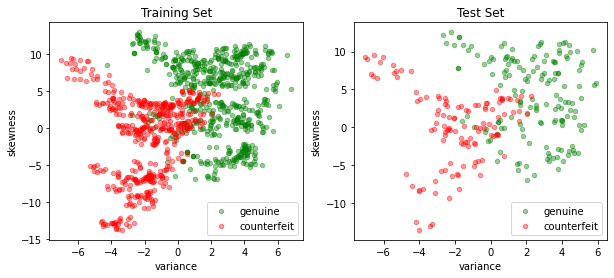

In [6]:
# plot training and test sets in two axes
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
scatter_labeled_data(
    X_train,
    y_train,
    labels=["genuine", "counterfeit"],
    ax=ax[0],
    title="Training Set",
)
scatter_labeled_data(
    X_test,
    y_test,
    labels=["genuine", "counterfeit"],
    ax=ax[1],
    title="Test Set",
)


## Support vector machines (SVM)

### Linear SVM classifier

A linear support vector machine (SVM) is a binary classification method that employs a linear equation to determine class assignment. The basic  formula is expressed as:

$$y^{pred} = \text{sgn}\ ( w^\top x + b)$$

where $x$ is a point $x\in\mathbb{R}^p$ in "feature" space. Here $w\in \mathbb{R}^p$ represents a set of coefficients, $w^\top x$ is the dot product, and $b$ is a scalar coefficient. The hyperplane defined by $w$ and $b$ separates the feature space into two classes. Points on one side of the hyperplane are have a positive outcome (+1); while points on the other side have a negative outcome (-1).

The following cell presents a simple Python implementation of a linear SVM. An instance of `LinearSVM` is defined with a coefficient vector $w$ and a scalar $b$. In this implementation, all data and parameters are provided as Pandas Series or DataFrame objects, and the Pandas `.dot()` function is used to compute the dot product.

In [7]:
# import required libraries
import pandas as pd
import numpy as np


# Linear Support Vector Machine (SVM) class
class LinearSVM:
    # Initialize the Linear SVM with weights and bias
    def __init__(self, w, b):
        """
        Args:
            w (Pandas Series or dictionary): Weights of the SVM
            b (float): Bias of the SVM
        """
        self.w = pd.Series(w)
        self.b = float(b)

    # Call method to compute the decision function
    def __call__(self, X):
        """
        Args:
            X (pandas.DataFrame): Input data

        Returns:
            numpy.array: Array of decision function values
        """
        return np.sign(X.dot(self.w) + self.b)

    # Representation method for the Linear SVM class
    def __repr__(self):
        """
        Returns:
            str: String representation of the Linear SVM
        """
        return f"LinearSvm(w = {self.w.to_dict()}, b = {self.b})"

A visual inspection of the banknote training set shows the two dimensional feature set can be approximately split along a vertical axis where "variance" is zero. Most of the positive outcomes are on the right of the axis, most of the negative outcomes on the left. Since $w$ is a vector normal to this surface, we choose 

$$
\begin{align}
    w & = \begin{bmatrix} w_{variance} \\ w_{skewness} \end{bmatrix} = \begin{bmatrix} 1 \\ 0 \end{bmatrix},
    \qquad b = 0
\end{align}
$$

The code cell below evaluates the accuracy of the linear SVM by calculating the **accuracy score**, which is the fraction of samples that were predicted accurately.

In [8]:
# Visual estimaate of w and b for a linear classifier
w = pd.Series({"variance": 1, "skewness": 0})
b = 0

# create an instance of LinearSVM
svm = LinearSVM(w, b)
print(svm)

# predictions for the training set
y_pred = svm(X_test)

# fraction of correct predictions
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Accuracy = {100 * accuracy: 0.1f}%")


LinearSvm(w = {'variance': 1, 'skewness': 0}, b = 0.0)
Accuracy =  82.9%


In [9]:
def scatter_comparison(X, y, y_pred):
    """
    Creates scatter plots comparing actual and predicted outcomes for both training and test sets.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Actual target vector as a Series.
    y_pred : Series
        Predicted target vector as a Series.

    Returns:
    None
    """

    xmin, ymin = X.min()
    xmax, ymax = X.max()
    xlim = [xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin)]
    ylim = [ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin)]

    # Plot training and test sets
    labels = ["genuine", "counterfeit"]
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter_labeled_data(
        X, y, labels, ["g", "r"], ax=ax[0], xlim=xlim, ylim=ylim, title="Actual"
    )
    scatter_labeled_data(
        X,
        y_pred,
        labels,
        ["c", "m"],
        ax=ax[1],
        xlim=xlim,
        ylim=ylim,
        title="Prediction",
    )

    # Plot actual positives and actual negatives
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter_labeled_data(
        X[y > 0],
        y_pred[y > 0],
        ["true positive", "false negative"],
        ["c", "m"],
        xlim=xlim,
        ylim=ylim,
        ax=ax[0],
        title="Actual Positives",
    )
    scatter_labeled_data(
        X[y < 0],
        y_pred[y < 0],
        ["false positive", "true negative"],
        ["c", "m"],
        xlim=xlim,
        ylim=ylim,
        ax=ax[1],
        title="Actual Negatives",
    )


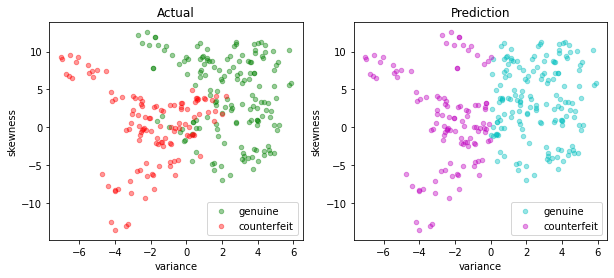

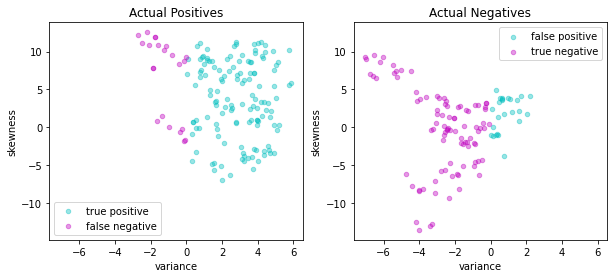

In [10]:
scatter_comparison(X_test, y_test, y_pred)

### Performance metrics

The accuracy score alone is not always a reliable metric for evaluating the performance of binary classifiers. For instance, when one outcome is significantly more frequent than the other, a classifier that always predicts the more common outcome without regard to the feature vector can achieve. Moreover, in many applications, the consequences of a false positive can differ from those of a false negative. For these reasons, we seek a more comprehensive set of metrics to compare binary classifiers. A [detailed discussion on this topic](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7) recommends the [Matthews correlation coefficient (MCC)](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a) as a reliable performance measure for binary classifiers.

The code below demonstrates an example of a function that evaluates the performance of a binary classifier and returns the Matthews correlation coefficient as its output.

In [11]:
def validate(y_true, y_pred, verbose=True):
    """
    This function calculates and displays the sensitivity, precision, and Matthews correlation coefficient
    (MCC) for a binary classifier based on its true labels (y_true) and predicted labels (y_pred).

    Args:
    y_true (array-like): A list or array containing the true labels of the samples.
    y_pred (array-like): A list or array containing the predicted labels of the samples.
    verbose (bool, optional): If True, the function prints and displays the calculated metrics and
                              confusion matrix. Defaults to True.

    Returns:
    float: The calculated Matthews correlation coefficient (MCC).
    """

    # Calculate the elements of the confusion matrix
    true_positives = sum((y_true > 0) & (y_pred > 0))
    false_negatives = sum((y_true > 0) & (y_pred < 0))
    false_positives = sum((y_true < 0) & (y_pred > 0))
    true_negatives = sum((y_true < 0) & (y_pred < 0))
    total = true_positives + true_negatives + false_positives + false_negatives

    # Calculate the Matthews correlation coefficient (MCC)
    mcc_numerator = (true_positives * true_negatives) - (
        false_positives * false_negatives
    )
    mcc_denominator = np.sqrt(
        (true_positives + false_positives)
        * (true_positives + false_negatives)
        * (true_negatives + false_positives)
        * (true_negatives + false_negatives)
    )
    mcc = mcc_numerator / mcc_denominator

    if verbose:
        print(f"Matthews correlation coefficient (MCC) = {mcc:0.3f}")

        # report sensitivity and precision, and accuracy
        sensitivity = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        accuracy = (true_positives + true_negatives) / total

        print(f"Sensitivity = {100 * sensitivity: 0.1f}%")
        print(f"Precision = {100 * precision: 0.1f}%")
        print(f"Accuracy = {100 * accuracy: 0.1f}%")

        # Display the binary confusion matrix
        confusion_matrix = pd.DataFrame(
            [
                [true_positives, false_negatives],
                [false_positives, true_negatives],
            ],
            index=["Actual Positive", "Actual Negative"],
            columns=["Predicted Positive", "Predicted Negative"],
        )
        display(confusion_matrix)

    return mcc


LinearSvm(w = {'variance': 1, 'skewness': 0}, b = 0.0) 

Matthews correlation coefficient (MCC) = 0.650
Sensitivity =  86.0%
Precision =  84.4%
Accuracy =  82.9%


,Predicted Positive,Predicted Negative
Actual Positive,135,22
Actual Negative,25,93


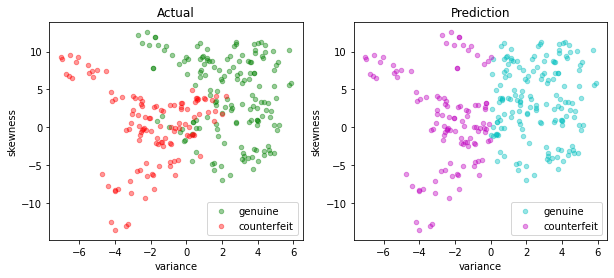

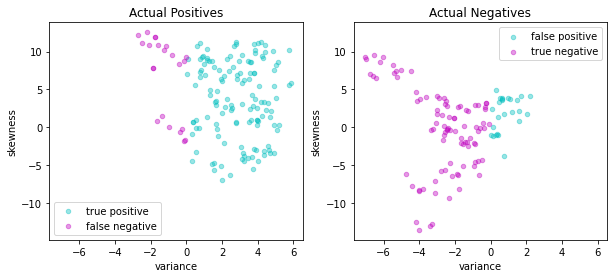

In [12]:
def test(svm, X_test, y_test):
    y_pred = svm(X_test)
    print(svm, "\n")
    validate(y_test, y_pred)
    scatter_comparison(X_test, y_test, y_pred)


# train and test
svm = LinearSVM({"variance": 1, "skewness": 0}, 0.0)
test(svm, X_test, y_test)


## Linear optimization model

A training or validation set consists of $n$ observations $(x_i, y_i)$ where $y_i = \pm 1$ and $x_i\in\mathbb{R}^p$ for $i=1, \dots, n$. The training task is to find coefficients $w\in\mathbb{R}^p$ and $b\in\mathbb{R}$ to achieve high sensitivity and high precision for the validation set. All points $(x_i, y_i)$ for $i\in 1, \dots, n$ are successfully classified if
 
$$
\begin{align}
    y_i (w^\top x_i + b) & > 0 & \forall i = 1, 2, \dots, n.
\end{align}
$$

As written, this condition imposes no scale for $w$ or $b$ (that is, if the condition is satisfied for any pair $(w, b)$, then it also satisfied for $(\gamma w, \gamma b)$ where $\gamma > 0$). To remove the ambiguity, a modified condition for correctly classified points is given by

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 & \forall i = 1, 2, \dots, n
\end{align*}
$$

which defines a **hard-margin** classifier. The size of the margin is determined by the scale of $w$ and $b$. 

In practice, it is not always possible to find $w$ and $b$ that perfectly separate all data. The condition for a hard-margin classifier is therefore relaxed by introducing non-negative decision variables $z_i \geq 0$ where

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 - z_i & \forall i = 1, 2, \dots, n
\end{align*}
$$

The variables $z_i$ measure the distance of a misclassified point from the separating hyperplane. An equivalent notation is to rearrange this expression as

$$
\begin{align*}
    z_i & = \max(0,  1 -  y_i (w^\top x_i + b)) & \forall i = 1, 2, \dots, n
\end{align*}
$$

which is **hinge-loss** function. The training problem is formulated as minimizing the hinge-loss function over all the data samples:

$$
\begin{align*}
    \min_{w, b} \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ .
\end{align*}
$$

Practice has shown that minimizing this term alone produces classifiers with large entries for $w$ which performs poorly on new data samples. For that reason, **regularization** adds a term to penalize the magnitude of $w$. In most formulations a norm $\|w\|$ is used for regularization, commonly a sum of squares such as $\|w\|_2^2$. Another choice is $\|w\|_1$ which, similar to Lasso regression, may result in sparse weighting vector $w$ indicating the elements of the feature vector that can be neglected for classification purposes. These considerations result in the objective function

$$
    \min_{w, b}\left[ \lambda \|w\|_1 + \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ \right]
$$

The needed weights are a solution to following LP:

$$
\begin{align*}
\min\quad  & \lambda \|w\|_1 + \frac{1}{n} \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i\geq 0 & \forall i = 1, \dots, n \\
& w\in\mathbb{R}^p \\
& b\in\mathbb{R} \\
\end{align*}
$$

This is the primal optimization problem in decision variables $w\in\mathbb{R}^p$, $b\in\mathbb{R}$, and $z\in\mathbb{R}^n$, a total of $n + p + 1$ unknowns with $2n$ constraints. This can be recast as a linear program with the usual technique of setting $w = w^+ - w^-$ where $w^+$ and $w^-$ are non-negative. Then

$$
\begin{align*}
\min\quad  &\lambda \sum_{j=1}^p (w^+_j + w^-_j) + \frac{1}{n}  \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i((w^+ - w^-)^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i \geq 0 & \forall i = 1, \dots, n \\
& w^+_j, w^-_j \geq 0 & \forall j = 1, \dots, p \\
& b\in\mathbb{R} \\
\end{align*}
$$

### AMPL implementation

The AMPL implementation is a **factory** function. The function accepts a set of training data, creates and solves an AMPL model for $w$ and $b$, then returns a trained `LinearSVM` object that can be applied to a other feature data.

LinearSvm(w = {'variance': 0.2433455986680064, 'skewness': 0.05752769715079136}, b = 0.007801888894288384) 

Matthews correlation coefficient (MCC) = 0.727
Sensitivity =  94.3%
Precision =  84.1%
Accuracy =  86.5%


,Predicted Positive,Predicted Negative
Actual Positive,148,9
Actual Negative,28,90


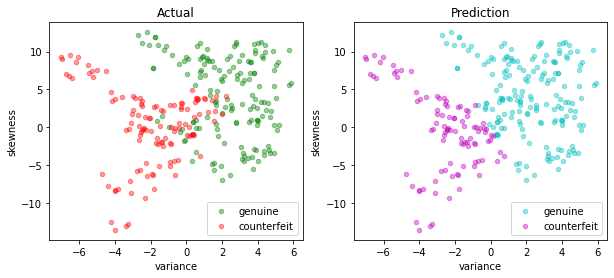

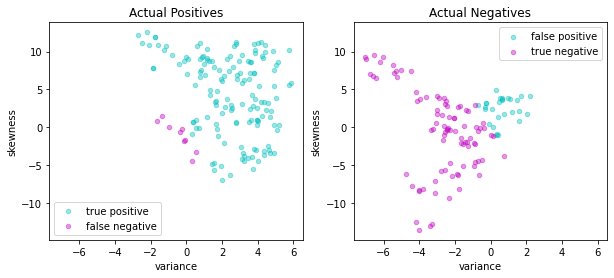

In [13]:
def svm_factory_lp(X, y, lambd=1):
    """
    Creates a linear support vector machine (SVM) model using linear programming.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Target vector as a Series.
    lambd : float, optional
        Regularization parameter. Default is 1.

    Returns:
    LinearSvm :
        A trained linear SVM model.
    """

    m = AMPL()
    
    m.eval("""
        set P;
        set N;
        
        param lambd;
        param X{P,N};
        param y{N};
        
        # Decision variables
        var wp{P} >= 0;
        var wn{P} >= 0;
        var b;
        var z{N} >= 0;
        var w{p in P} = wp[p] - wn[p];
        
        minimize lasso: sum{i in N} z[i] / card(N)
                            + lambd * sum{p in P} (wp[p]+wn[p]);
        
        subject to hingeloss{i in N}:
            z[i] >= 1-y[i]*(sum{p in P} w[p]*X[p,i] + b);
        
    """)
    
    # Use dataframe columns and index to index variables and constraints
    m.set['P'] = list(X.columns)
    m.set['N'] = np.array(X.index)
    
    m.param['lambd'] = lambd
    m.param['y'] = y
    
    m.param['X'] = X.unstack()

    m.option['solver'] = SOLVER_LO

    m.get_output('solve;')

    w = pd.Series([m.var['w'][p].value() for p in X.columns], index=X.columns)
    b = m.var['b'].value()

    return LinearSVM(w, b)


# Train and test
svm_lp = svm_factory_lp(X_train, y_train)
test(svm_lp, X_test, y_test)


## Quadratic programming model

### Primal form

The standard formulation of a linear support vector machine uses training sets with $p$-element feature vectors $x_i\in\mathbb{R}^p$ along with classification labels for those vectors, $y_i = \pm 1$. A classifier is defined by two parameters: a weight vector $w\in\mathbb{R}^p$ and a bias term $b\in\mathbb{R}$

$$
\begin{align*}
y^{pred} & = \text{sgn}(w^\top x + b)
\end{align*}
$$

If a separating hyperplane exists, then we choose $w$ and $b$ so that a hard-margin classifier exists for the training set $(x_i, y_i)$ where

$$
\begin{align*}
y_i \left( w^\top x_i + b \right) & \geq 1 & \forall i \in 1, 2, \dots, n
\end{align*}
$$

This can always be done if a separating hyperplane exists. But if a separating hyperplane does not exist, we introduce non-negative slack variables $z_i$ to relax the constraints and settle for a soft-margin classifier 

$$
\begin{align*}
y_i \left( w^\top x_i + b \right) & \geq 1 - z_i& \forall i \in 1, 2, \dots, n
\end{align*}
$$ 

The training objective is to minimize the total distance to misclassified data points. This leads to the optimization problem

$$
\begin{align*}
\min\quad  & \frac{1}{2} \|w \|_2^2 + \frac{c}{n} \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i\geq 0 & \forall i = 1, \dots, n \\
& w\in\mathbb{R}^p \\
& b\in\mathbb{R} \\
\end{align*}
$$

where $\frac{1}{2} \|\bar{w}\|_2^2$ is included to regularize the solution for $w$. Choosing larger values of $c$ will reduce the number and size of misclassifications. The trade-off will be larger weights $w$ and the accompanying risk of over over-fitting the training data. 

LinearSvm(w = {'variance': 0.3026702238984385, 'skewness': 0.09531457904462999}, b = -0.07960731565014348) 

Matthews correlation coefficient (MCC) = 0.732
Sensitivity =  91.1%
Precision =  86.7%
Accuracy =  86.9%


,Predicted Positive,Predicted Negative
Actual Positive,143,14
Actual Negative,22,96


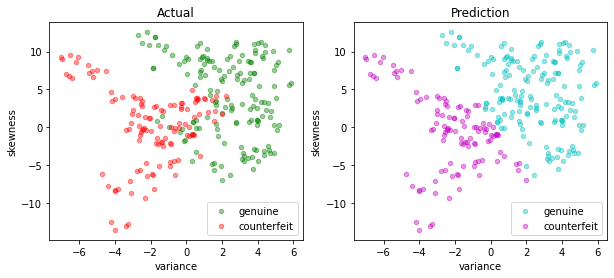

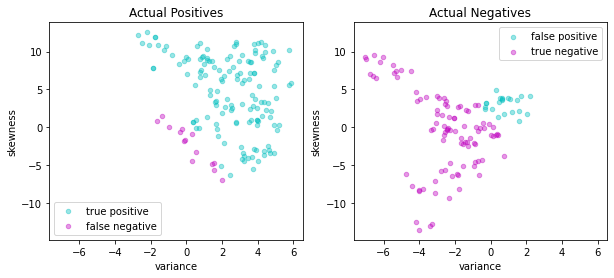

In [14]:
def svm_factory_qp(X, y, c=1):
    """
    Creates a linear support vector machine (SVM) model using quadratic programming.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Target vector as a Series.
    c : float, optional
        Regularization parameter. Default is 1.

    Returns:
    LinearSvm :
        A trained linear SVM model.
    """

    m = AMPL()
    
    m.eval("""
        set P;
        set N;
        
        param c;
        param X{P,N};
        param y{N};
        
        # Decision variables
        var b;
        var z{N} >= 0;
        var w{P};
        
        minimize qp: c / card(N) * sum{i in N} z[i]
                            + sum{p in P} w[p]^2;
        
        subject to hingeloss{i in N}:
            z[i] >= 1-y[i]*(sum{p in P} w[p]*X[p,i] + b);
        
    """)
    
    # Use dataframe columns and index to index variables and constraints
    m.set['P'] = list(X.columns)
    m.set['N'] = np.array(X.index)
    
    m.param['c'] = c
    m.param['y'] = y
    
    m.param['X'] = X.unstack()

    # Solve QP with the interior point method
    m.option['solver'] = SOLVER_NLO

    m.get_output('solve;')
    
    P = m.set['P'].members()
    
    # Extract solution
    w = pd.Series([m.var['w'][p].value() for p in X.columns], index=X.columns)
    b = m.var['b'].value()

    return LinearSVM(w, b)


# Train and test
svm_lp = svm_factory_qp(X_train, y_train)
test(svm_lp, X_test, y_test)


### Dual Formulation

The dual formulation for the SVM provides insight into how a linear SVM works and essential for extending SVM to nonlinear classification. The dual formulation begins by creating a differentiable Lagrangian with dual variables $\alpha_i \geq 0$ and $\beta_i \geq 0$ for $i = 1, \dots, n$. The task is to find saddle points of

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|w\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i \left(1 - z_i - y_i (w^\top x_i + b) \right) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

Taking derivatives with respect to the primal variables

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
\frac{\partial \mathcal{L}}{\partial w} & = w  - \sum_{i=1}^n \alpha_i y_i x_i = 0 \implies  w = \sum_{i=1}^n \alpha_i y_i x_i \\
\frac{\partial \mathcal{L}}{\partial b} & = - \sum_{i=1}^n \alpha_i y_i = 0 \implies \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}
$$

This can be arranged in the form of a standard quadratic program in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( x_i^\top x_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0  \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

The symmetric $n \times n$ **Gram matrix** is defined as

$$
    G = \begin{bmatrix} 
        (y_1 x_1^\top)(y_1 x_1) & \dots & (y_1 x_1^\top)(y_n x_n) \\ 
        \vdots & \ddots & \vdots \\ 
        (y_n x_n^\top)(y_1 x_1) & \dots & (y_n x_n^\top)(y_n x_n)
    \end{bmatrix}
$$

where each entry is dot product of two vectors $(y_i x_i), (y_j x_j) \in \mathbb{R}^{p+1}$. 

Compared to the primal, the dual formulation appears to have reduced the number of decision variables from $n + p + 1$ to $n$. But this has come with the penalty of introducing a dense matrix with $n^2$ coefficients and potential processing time of order $n^3$. For large training sets where $n\sim 10^4-10^6$ or even larger, this becomes a prohibitively expensive calculation. In addition, the Gram matrix will be rank deficient for cases $p< n$. 

We can eliminates the need to compute and store the full Gram matrix $G$ by introducing the $n \times p$ matrix $F$
 
$$
    F = \begin{bmatrix} y_1 x_1^\top \\ y_2 x_2^\top \\ \vdots \\ y_n x_n^\top \end{bmatrix}
$$

Then $G = FF^\top$ which brings the $p$ primal variables $w = F^\top\alpha$ back into the computational problem. The optimization problem becomes

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} w^\top w -  1^\top\alpha \\
\text{s. t.}\quad & y^\top\alpha = 0 \\
& w = F^\top\alpha & w\in\mathbb{R}^p \\
& 0 \leq \alpha_i \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The solution for the bias term $b$ is obtained by considering the complementarity conditions on the dual variables. The slack variables $z_i$ are zero if $\beta_i > 0$ which is equivalent to $\alpha_i < \frac{c}{n}$. If $\alpha_i > 0$ then $1 - y_i (w^\top x_i + b)$. Putting these facts together gives a formula for $b$

$$
\begin{align}
b & = y_i - w^\top x_i & \forall i\in 1, 2, \ldots, n\quad \text{s.t.}\quad 0 < \alpha_i < \frac{c}{n}\\
\end{align}
$$

This model is implemented below.

LinearSvm(w = {'variance': 0.3612831425509601, 'skewness': 0.12051653567053186}, b = -0.11379837305403229) 

Matthews correlation coefficient (MCC) = 0.724
Sensitivity =  90.4%
Precision =  86.6%
Accuracy =  86.5%


,Predicted Positive,Predicted Negative
Actual Positive,142,15
Actual Negative,22,96


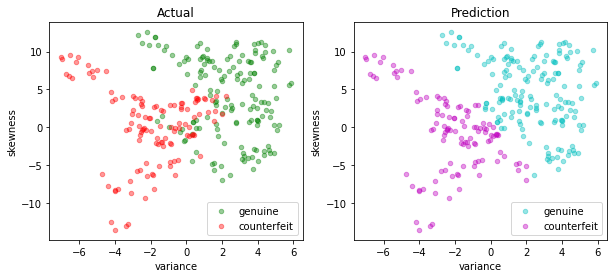

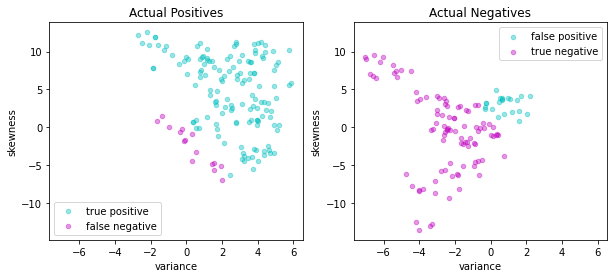

In [15]:
def svm_factory_dual(X, y, c=1):
    """
    Creates a linear support vector machine (SVM) model using the dual formulation
    and quadratic programming.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Target vector as a Series.
    c : float, optional
        Regularization parameter. Default is 1.

    Returns:
    LinearSvm :
        A trained linear SVM model.
    """

    m = AMPL()
    
    m.eval("""
        set P;
        set N;
        
        param y{N};
        param F{P,N};
        param C;
        
        # Decision variables
        var w{P};
        var a{N} >= 0 <= C;

        minimize qp: 1/2 * sum{p in P} w[p]^2 - sum{i in N} a[i];
            
        subject to bias:
            sum{i in N} y[i] * a[i] = 0;

        subject to projection{p in P}:
            w[p] = sum{i in N} F[p,i] * a[i];
    """)
    
    # Use dataframe columns and index to index variables and constraints
    m.set['P'] = list(X.columns)
    m.set['N'] = np.array(X.index)

    # Model parameters
    C = c/len(X.index)
    m.param['C'] = C
    m.param['y'] = y
    m.param['F'] = X.mul(y, axis=0).unstack()
    
    # Solve QP with the interior point method
    m.option['solver'] = SOLVER_NLO

    m.get_output('solve;')
    
    P = m.set['P'].members()
    N = m.set['N'].members()

    # Extract solution
    w = pd.Series([m.var['w'][p].value() for p in X.columns], index=X.columns)
    a = pd.Series([m.var['a'][i].value() for i in X.index], index=X.index)
    
    # Find alpha closest to the center of [0, c/n]
    i = a.index[(a - C / 2).abs().argmin()]
    b = y.loc[i] - X.loc[i, :].dot(w)

    return LinearSVM(w, b)


# Train and test
svm_lp = svm_factory_dual(X_train, y_train)
test(svm_lp, X_test, y_test)


## Kernelized SVM

### Nonlinear feature spaces

A linear SVM assumes the existence of a linear hyperplane that separates labeled sets of data points. Frequently, however, this is not possible and some sort of nonlinear method is needed. 

Consider a binary classification done given by a function

$$y^{pred} = \text{sgn} \left( w^\top \phi(x) + b \right)$$

where $\phi(x)$ is a function mapping $x$ into a higher dimensional "feature space". That is, $\phi : \mathbb{R}^{p} \rightarrow \mathbb{R}^d$ where $d \geq p $. The additional dimensions may include features such as powers of the terms in $x$, or products of those terms, or other types of nonlinear transformations. As before, we wish to find a choice for $w\in\mathbb{R}^d$ such that the soft-margin classifier

$$
\begin{align}
y_i \left( w^\top \phi(x_i) + b \right) & \geq 1 - z_i  & i = 1, 2, \ldots, n
\end{align}
$$

Using the machinery as before, we set up the Lagrangian

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|w\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i \left( 1 - z_i - y_i \left( w^\top \phi(x_i) + b \right)\right) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

then take derivatives to find

$$
\begin{align*}
    \frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
    \frac{\partial \mathcal{L}}{\partial w} & = w  - \sum_{i=1}^n \alpha_i y_i \phi(x_i) = 0 \implies  w = \sum_{i=1}^n \alpha_i y_i \phi(x_i) \\
\frac{\partial \mathcal{L}}{\partial b} & = - \frac{c}{n}\sum_{i=1}^n \alpha_i y_i = 0 \implies \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}
$$

This is similar to the case of a linear SVM, but now the vector of weights $w\in\mathbb{R}^d$ which can be a  high dimensional space with nonlinear features. Working through the algebra, we are once again left with a quadratic program in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\quad  & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j  \phi(x_i)^\top \phi(x_j) -  \sum_{i=1}^n \alpha_i \\
\text{s.t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
& \sum_{i=1}^n \alpha_i y_i = 0 \\
\end{align*}
$$

where the resulting classifier is given by 

$$y^{pred} = \text{sgn} \left( \sum_{i=1}^n \alpha_i y_i \phi(x_i)^\top \phi(x) + b \right)$$

### The kernel trick

This is an interesting situation where the separating hyperplane is embedded in a high dimensional space of nonlinear features determined by the mapping $\phi(x)$, but all we need for computation are the inner products  $\phi(x_i)^\top\phi(x_j)$ to train the classifier, and the inner products $\phi(x_i)^\top\phi(x)$ to use the classifier. If we had a function $K(x, z)$ that returned the value $\phi(x)^\top\phi(z)$ then we would never need to actually compute $\phi(x)$, $\phi(z)$ or their inner product.

Mercer's theorem turns the analysis on its head by specifying conditions for which a function $K(x, z)$ to be expressed as an inner product for some $\phi(x)$. If $K(x, z)$ is symmetric (i.e, $K(x, z) = K(z, x)$, and if the Gram matrix constructed for any collection of points $x_1, x_2, \ldots, x_n$ 

$$
\begin{bmatrix} 
    K(x_1, x_1) & \dots & K(x_1, x_n) \\ 
    \vdots & \ddots & \vdots \\ 
    K(x_n, x_1) & \dots & K(x_n, x_n) 
\end{bmatrix}
$$

is positive semi-definite, then there is some $\phi(x)$ for which $K(x, z)$ is an inner product. We call such functions kernels. The practical consequence is that we can train and implement nonlinear classifiers using kernel and without ever needing to compute the higher dimensional features. This remarkable result is called the "kernel trick".

### Implementation

To take advantage of the kernel trick, we assume an appropriate kernel $K(x, z)$ has been identified, then replace all instances of $\phi(x_i)^\top \phi(x)$ with the kernel. The "kernelized" SVM is given by a solution to 

$$
\begin{align*}
\min_{\alpha_i}\quad & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j) -  \sum_{i=1}^n \alpha_i \\
\text{s.t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where

$$
\begin{align}
b & = y_i - \sum_{j=1}^n \alpha_j y_j K(x_j, x_i) & \forall i\in 1, 2, \ldots, n\quad \text{s.t.}\quad 0 < \alpha_i < \frac{c}{n}
\end{align}
$$

where the resulting classifier is given by 

$$y^{pred} = \text{sgn} \left( \sum_{i=1}^n \alpha_i y_i K(x_i, x) + b \right)$$

We define the $n\times n$ positive symmetric semi-definite Gram matrix

$$
G = \begin{bmatrix} 
    y_1 y_1 K(x_1, x_1) & \dots & y_1 y_n K(x_1, x_n) \\ 
    \vdots & \ddots & \vdots \\ 
    y_n y_1 K(x_n, x_1) & \dots & y_n y_n K(x_n, x_n) 
\end{bmatrix}
$$

We factor $G = F F^\top$ where $F$ has dimensions $n \times q$ and where $q$ is the rank of $G$. The factorization is not unique. As demonstrated in the Python code below, one suitable factorization is the spectral factorization $G = U\Lambda U^T$ where $\Lambda$ is a $q\times q$ diagonal matrix of non-zero eigenvalues, and $U$ is an $n\times q$ normal matrix such that $U^\top U = I_q$. Then

$$F = U\Lambda^{1/2}$$

Once this factorization is complete, the optimization problem for the kernalized SVM is the same as for the linear SVM in the dual formulation

$$
\begin{align*}
\min\quad & \frac{1}{2} \alpha^\top F F^\top \alpha -  1^\top \alpha \\
\text{s.t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& 0 \leq \alpha_i \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The result is a quadratic program for the dual coefficients $\alpha$ and auxiliary variables $v$.

$$
\begin{align*}
\min\quad & \frac{1}{2} v^\top v - 1^\top \alpha\\
\text{s.t.}\quad & y^\top \alpha = 1 \\
& v = F^\top \alpha & u\in\mathbb{R}^{q} \\
& 0 \leq \alpha_i \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

Summarizing, the essential difference between training the linear and kernelized SVM is the need to compute and factor the Gram matrix. The result will be a set of non-zero coefficients $\alpha_i > 0$ the define a set of support vectors $\mathcal{SV}$. The classifier is then given by

$$y^{pred} = \text{sgn} \left( \sum_{i\in\mathcal{SV}} \alpha_i y_i K(x_i, x) + b \right)$$

The implementation of the kernelized SVM is split into two parts. The first part is a class used to create instances of the classifier.


In [16]:
import pandas as pd
import numpy as np


class KernelSVM:
    """
    Kernel Support Vector Machine (SVM) class.
    """

    def __init__(self, X, y, a, b, kernel):
        """
        Initialize the Kernel SVM with weights and bias.

        :param X: numpy array or list, training data.
        :param y: numpy array or list, target labels.
        :param a: numpy array or list, alpha values for the support vectors.
        :param b: float, bias value.
        :param kernel: function, kernel function to be used in the SVM.
        """
        self.X = np.array(X)
        self.u = np.multiply(np.array(a), np.array(y))
        self.b = b
        self.kernel = kernel

    def __call__(self, Z):
        """
        Compute the decision function.

        :param Z: pandas DataFrame, test data.
        :return: pandas Series, predicted labels.
        """
        K = [
            [self.kernel(self.X[i, :], Z.loc[j, :]) for j in Z.index]
            for i in range(len(self.X))
        ]
        y_pred = np.sign((self.u @ K) + self.b)
        return pd.Series(y_pred, index=Z.index)

    def __repr__(self):
        """
        Returns:
            str: String representation of the Linear SVM
        """
        return f"KernelSvm(b = {self.b})"

The second part of the implementation is a factory function containing the optimization model for training an SVM. Given training data and a kernal function, the factory returns an instance of a kernelized SVM. The default is a linear kernel.

In [17]:
def svm_factory_kernel(X, y, c=1, tol=1e-8, kernel=lambda x, z: x @ z):
    """
    Creates a linear support vector machine (SVM) model using the dual formulation
    and quadratic programming.

    Parameters:
    X : DataFrame
        Feature matrix as a DataFrame.
    y : Series
        Target vector as a Series.
    c : float, optional
        Regularization parameter. Default is 1.

    Returns:
    LinearSvm :
        A trained linear SVM model.
    """
    
    # Convert to numpy arrays for speed improvement
    n, p = X.shape
    X_ = X.to_numpy()
    y_ = y.to_numpy()

    # Gram matrix
    G = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            G[j, i] = G[i, j] = y_[i] * y_[j] * kernel(X_[i, :], X_[j, :])

    # Factor the Gram matrix
    eigvals, eigvecs = np.linalg.eigh(G)
    idx = eigvals >= tol * max(eigvals)
    F = pd.DataFrame(
        eigvecs[:, idx] @ np.diag(np.sqrt(eigvals[idx])), index=X.index
    )

    # Build model
    m = AMPL()
    
    m.eval("""
        set Q;
        set N;
        
        param y{N};
        param F{Q,N};
        param C;
        
        # Decision variables
        var u{Q};
        var a{N} >= 0 <= C;

        minimize qp: 1/2 * sum{q in Q} u[q]^2 - sum{i in N} a[i];
            
        subject to bias:
            sum{i in N} y[i] * a[i] = 0;

        subject to projection{q in Q}:
            u[q] = sum{i in N} F[q,i] * a[i];
    """)
    
    # Use dataframe columns and index to index variables and constraints
    m.set['Q'] = list(F.columns)
    m.set['N'] = np.array(F.index)

    # Model parameters
    C = c/len(F.index)
    m.param['C'] = C
    m.param['y'] = y
    m.param['F'] = F.unstack()
    
    # Solve QP with the interior point method
    m.option['solver'] = SOLVER_NLO

    m.get_output('solve;')
    
    # Extract solution
    a = pd.Series([m.var['a'][i].value() for i in X.index], index=X.index)
    
    # Find b by locating a closest to the center of [0, c/n]
    j = a.index[(a - C / 2).abs().argmin()]
    b = y.loc[j] - sum(
        [a[i] * y.loc[i] * kernel(X.loc[i, :], X.loc[j, :]) for i in X.index]
    )

    # Display the support vectors
    y_support = pd.Series(
        [1 if a[i] > 1e-4 * C else -1 for i in X.index], index=X.index
    )
    scatter_labeled_data(
        X,
        y_support,
        colors=["b", "y"],
        labels=["Support Vector", ""],
        title="Support Vectors",
    )

    # Find support vectors
    SV = [i for i in X.index if a[i] > 1e-3 * C]

    return KernelSVM(X.loc[SV, :], y.loc[SV], a.loc[SV], b, kernel)

### Linear kernel

For comparison with the previous cases, the first kernel we consider is a linear kernel

$$ K(x, z) = x^\top z $$

which should reproduce the results obtained earlier.

KernelSvm(b = -0.11396030776136823) 

Matthews correlation coefficient (MCC) = 0.724
Sensitivity =  90.4%
Precision =  86.6%
Accuracy =  86.5%


,Predicted Positive,Predicted Negative
Actual Positive,142,15
Actual Negative,22,96


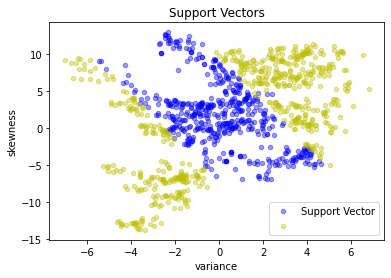

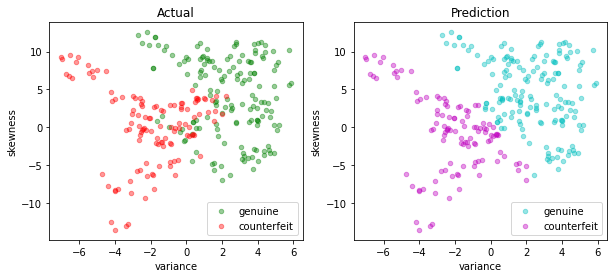

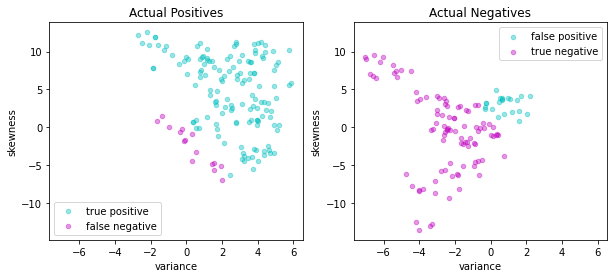

In [18]:
svm_kernel = svm_factory_kernel(X_train, y_train)
test(svm_kernel, X_test, y_test)

### Polynomial kernels

A polynomial kernel of order $d$ has the form

$$K(x, z) = (1 + x^\top z)^d$$

The following cell demonstrates a quadratic kernel applied to the banknote data.


KernelSvm(b = -0.6403102143084767) 

Matthews correlation coefficient (MCC) = 0.777
Sensitivity =  90.4%
Precision =  90.4%
Accuracy =  89.1%


,Predicted Positive,Predicted Negative
Actual Positive,142,15
Actual Negative,15,103


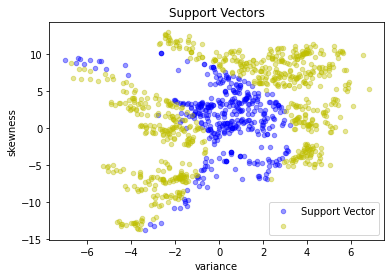

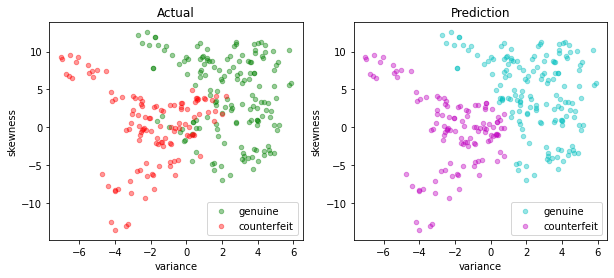

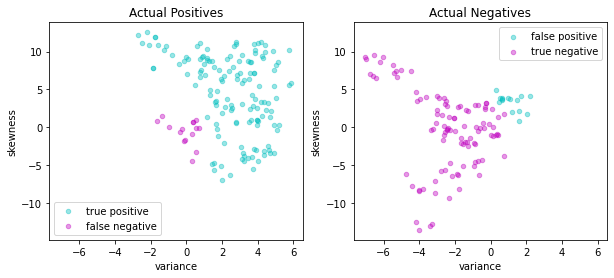

In [19]:
quadratic = lambda x, z: (1 + x @ z) ** 2

svm_kernel = svm_factory_kernel(X_train, y_train, kernel=quadratic)
test(svm_kernel, X_test, y_test)


KernelSvm(b = -1.7294231602167724) 

Matthews correlation coefficient (MCC) = 0.816
Sensitivity =  84.1%
Precision =  98.5%
Accuracy =  90.2%


,Predicted Positive,Predicted Negative
Actual Positive,132,25
Actual Negative,2,116


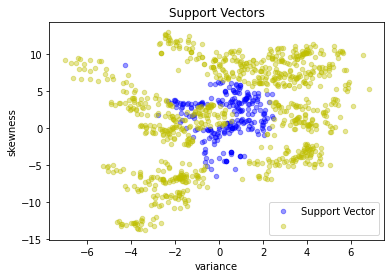

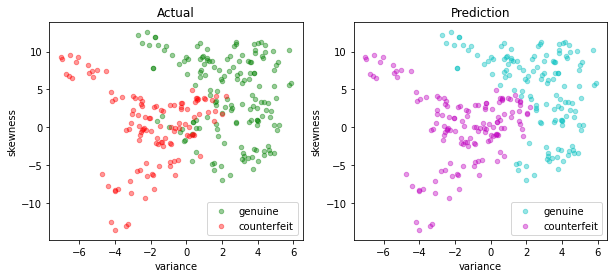

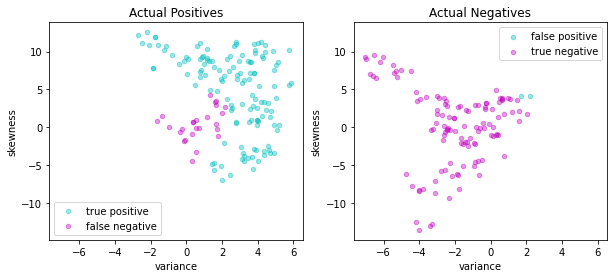

In [20]:
cubic = lambda x, z: (1 + x @ z) ** 3

svm_kernel = svm_factory_kernel(X_train, y_train, kernel=cubic)
test(svm_kernel, X_test, y_test)
